<a href="https://colab.research.google.com/github/rtajeong/Kyungnam_univ_M4/blob/main/lab_58_MNIST_tensorflow_rev3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST with RandomForest

In [6]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import utils
import matplotlib.pyplot as plt

(X_train, Y_class_train), (X_test, Y_class_test) = mnist.load_data()
X_train.shape, Y_class_test.shape

((60000, 28, 28), (10000,))

In [7]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=50)
rfc.fit(X_train.reshape(X_train.shape[0], 28*28), Y_class_train)
rfc.score(X_test.reshape(X_test.shape[0], 28*28), Y_class_test)

0.9666

# MNIST with Tensorflow 2.0 (version 1)
- from internet
- Multi-class logistic regression (simple MLP without hidden layer)
- https://builtin.com/data-science/guide-logistic-regression-tensorflow-20




In [8]:
# step 1: importing modules

import tensorflow as tf
import numpy as np

In [9]:
# step 2: loading and preparing mnist dataset

from tensorflow.keras.datasets import mnist
num_classes = 10        # 0 to 9 digits
num_features = 28 * 28
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
x_train, x_test = x_train / 255., x_test / 255.

In [10]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000,), (10000,))

In [11]:
# step 3: setting up hyperparameters and dataset parameters

learning_rate = 0.01
training_steps = 2000
batch_size = 256
display_step = 50

In [12]:
# step 4: shuffling and batching the dataset
# - Prefetching overlaps the preprocessing and model execution of a training step. 
#   While the model is executing training step s, the input pipeline is reading 
#   the data for step s+1. Doing so reduces the step time to the maximum (as 
#   opposed to the sum) of the training and the time it takes to extract the data.

train_data=tf.data.Dataset.from_tensor_slices((x_train,y_train))
# train_data=train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)
train_data=train_data.repeat().shuffle(5000).batch(batch_size)

In [13]:
train_data

<BatchDataset shapes: ((None, 784), (None,)), types: (tf.float32, tf.uint8)>

In [14]:
# step 5: initializing weights and biases

W = tf.Variable(tf.random.normal([num_features, num_classes]), name="weight") # (784,10)
b = tf.Variable(tf.random.normal([num_classes]), name="bias")                # (10,)
W, b

(<tf.Variable 'weight:0' shape=(784, 10) dtype=float32, numpy=
 array([[ 0.14641725, -1.275717  , -0.41529584, ..., -0.00662114,
          0.96034604, -0.6888237 ],
        [ 0.7270821 ,  0.03041806, -0.1917843 , ..., -0.609361  ,
         -0.1811534 , -0.19635953],
        [-0.6277022 ,  1.9204644 ,  1.6528785 , ...,  0.52491087,
          0.70311266,  0.42984638],
        ...,
        [-1.226097  ,  0.4846938 ,  0.6213343 , ...,  1.8014935 ,
          1.3762915 , -1.7004398 ],
        [ 0.6446411 , -0.17726664, -0.7133045 , ..., -0.40442947,
          0.67478836,  1.3981873 ],
        [ 1.3505956 ,  0.6761066 ,  2.3056579 , ..., -0.86941814,
          0.83873314, -0.32873645]], dtype=float32)>,
 <tf.Variable 'bias:0' shape=(10,) dtype=float32, numpy=
 array([ 1.6833035 , -0.606919  , -0.06063361, -0.65168977, -1.3462218 ,
         0.5435195 , -0.02910734,  0.24136437,  2.3162153 , -0.06374669],
       dtype=float32)>)

In [15]:
# step 6: defining logistic regression and cost function

def logistic_regression(x):
    return tf.nn.softmax(tf.matmul(x, W) + b)

def cross_entropy(y_pred, y_true):
    y_true = tf.one_hot(y_true, depth=num_classes)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)  # to avoid log(0) error
    ce1 = tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1))
    ce0 = tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))       # wrong
    ce2 = tf.reduce_mean(tf.losses.categorical_crossentropy(y_true, y_pred)) # function
    return ce1

In [16]:
# step 7: defining optimizers and accuracy metrics

def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64)) # axis=1
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

optimizer = tf.optimizers.Adam(learning_rate)

In [17]:
# step 8: optimization process and updating weights and biases

def run_optimization(x, y):
    
    with tf.GradientTape() as tape:
        y_pred = logistic_regression(x)
        loss = cross_entropy(y_pred, y)

    gradients = tape.gradient(loss, [W, b])
    optimizer.apply_gradients(zip(gradients, [W, b]))  # updates

In [18]:
# step 9: the training loop
# dataset.take(c): Creates a Dataset with at most c elements from this dataset.
# batch_size 만큼씩  c 번 뽑는다.

for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):

    # print(batch_x.shape, batch_y.shape)   # (256,784), (256,)
    run_optimization(batch_x, batch_y)

    if step % display_step == 0:
        pred = logistic_regression(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

step: 50, loss: 2.352834, accuracy: 0.632812
step: 100, loss: 1.370897, accuracy: 0.769531
step: 150, loss: 1.128205, accuracy: 0.808594
step: 200, loss: 0.498080, accuracy: 0.878906
step: 250, loss: 0.772145, accuracy: 0.878906
step: 300, loss: 0.800719, accuracy: 0.863281
step: 350, loss: 0.569871, accuracy: 0.886719
step: 400, loss: 0.507981, accuracy: 0.863281
step: 450, loss: 0.485246, accuracy: 0.894531
step: 500, loss: 0.507446, accuracy: 0.875000
step: 550, loss: 0.264344, accuracy: 0.910156
step: 600, loss: 0.279877, accuracy: 0.910156
step: 650, loss: 0.407820, accuracy: 0.898438
step: 700, loss: 0.392256, accuracy: 0.890625
step: 750, loss: 0.374940, accuracy: 0.925781
step: 800, loss: 0.407228, accuracy: 0.898438
step: 850, loss: 0.501180, accuracy: 0.875000
step: 900, loss: 0.414898, accuracy: 0.894531
step: 950, loss: 0.418544, accuracy: 0.898438
step: 1000, loss: 0.298932, accuracy: 0.902344
step: 1050, loss: 0.448940, accuracy: 0.898438
step: 1100, loss: 0.412466, accur

In [19]:
# step 10: testing model accuracy using the test data

pred = logistic_regression(x_test)
print("Test Accuracy: %f" % accuracy(pred, y_test))

Test Accuracy: 0.914700


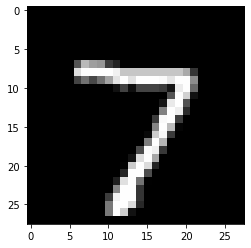

model prediction: 7


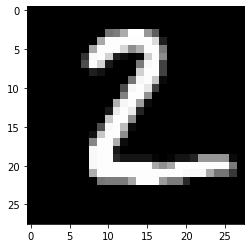

model prediction: 2


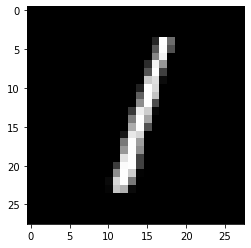

model prediction: 1


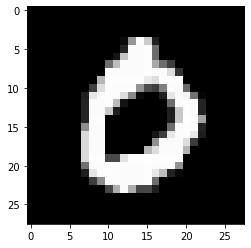

model prediction: 0


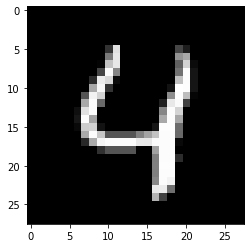

model prediction: 4


In [20]:
# step 11: visualizing the classification result

import matplotlib.pyplot as plt

n_images = 5
test_images = x_test[:n_images]
predictions = logistic_regression(test_images)

for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28,28]), cmap='gray')
    plt.show()
    print('model prediction: %i' %np.argmax(predictions.numpy()[i]))

# MNIST with tensorflow 2.0 (version 2)
- all in one code routine (for easy migration from the simpler regression code)
- my version

In [61]:
from tensorflow.keras.datasets import mnist
num_classes = 10        # 0 to 9 digits
num_features = 28 * 28
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
x_train, x_test = x_train / 255., x_test / 255.

In [74]:
input_size = 784
num_classes = 10
batch_size = 300
num_epochs = 10
learning_rate = 0.01

In [75]:
train_data=tf.data.Dataset.from_tensor_slices((x_train,y_train))
train_data=train_data.shuffle(5000).batch(batch_size)

In [76]:
W = tf.Variable(tf.random.normal([input_size, num_classes])) # (784,10)
b = tf.Variable(tf.random.normal([num_classes]))             # (10,)

In [77]:
# Training
for e in range( num_epochs ):
    for step, (batch_x, batch_y) in enumerate(train_data, 1):
        with tf.GradientTape() as tape:
            y_pred = tf.nn.softmax(tf.matmul(batch_x, W) + b)
            y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
            batch_y_ohe = tf.one_hot(batch_y, depth = 10)
            loss = tf.reduce_mean(tf.losses.categorical_crossentropy( batch_y_ohe , y_pred ))
            # loss = tf.reduce_mean(-tf.reduce_sum(batch_y * tf.math.log(y_pred), axis=1))

        grads = tape.gradient(loss, [W, b])
        optimizer = tf.optimizers.Adam( learning_rate )
        # Adam 과 SGD 비교해 보면 좋음.
        optimizer.apply_gradients(zip(grads, [W,b]))

        corr_predict = tf.equal(tf.argmax(y_pred, 1), tf.cast(batch_y, tf.int64))
        acc = tf.reduce_mean(tf.cast(corr_predict, tf.float32))

        if step % 50 == 0: 
           print("epoch: %i, step: %i, loss: %f, acc: %f" % (e, step, loss, acc))
    
    # print("epoch: %i, loss: %f, accuracy: %f" % (e, loss, acc))

# Testing
test_y_pred = tf.nn.softmax(tf.matmul(x_test, W) + b)
test_pred = tf.equal(tf.argmax(test_y_pred, 1), tf.cast(y_test, tf.int64))
test_acc = tf.reduce_mean(tf.cast(test_pred, tf.float32))

print("Test accuracy: %f" % test_acc)

epoch: 0, step: 50, loss: 1.967909, acc: 0.686667
epoch: 0, step: 100, loss: 0.909622, acc: 0.826667
epoch: 0, step: 150, loss: 0.609875, acc: 0.866667
epoch: 0, step: 200, loss: 0.503607, acc: 0.876667
epoch: 1, step: 50, loss: 0.479139, acc: 0.880000
epoch: 1, step: 100, loss: 0.755950, acc: 0.866667
epoch: 1, step: 150, loss: 0.708575, acc: 0.893333
epoch: 1, step: 200, loss: 0.350539, acc: 0.926667
epoch: 2, step: 50, loss: 0.555015, acc: 0.886667
epoch: 2, step: 100, loss: 0.548195, acc: 0.903333
epoch: 2, step: 150, loss: 0.433577, acc: 0.890000
epoch: 2, step: 200, loss: 0.189602, acc: 0.940000
epoch: 3, step: 50, loss: 0.561037, acc: 0.893333
epoch: 3, step: 100, loss: 0.346896, acc: 0.930000
epoch: 3, step: 150, loss: 0.393091, acc: 0.896667
epoch: 3, step: 200, loss: 0.232276, acc: 0.930000
epoch: 4, step: 50, loss: 0.687259, acc: 0.896667
epoch: 4, step: 100, loss: 0.581371, acc: 0.896667
epoch: 4, step: 150, loss: 0.574118, acc: 0.900000
epoch: 4, step: 200, loss: 0.347438,

# MNIST tensorflow 2.0 (version 3)
- function define

In [78]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import mnist
num_classes = 10        # 0 to 9 digits
num_features = 28 * 28
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
x_train, x_test = x_train / 255., x_test / 255.

input_size = 784
num_classes = 10
batch_size = 300
num_epochs = 10
learning_rate = 0.01

train_data=tf.data.Dataset.from_tensor_slices((x_train,y_train))
train_data=train_data.shuffle(5000).batch(batch_size)

W = tf.Variable(tf.random.normal([input_size, num_classes])) # (784,10)
b = tf.Variable(tf.random.normal([num_classes]))             # (10,)

def model(X):
    return tf.nn.softmax(tf.matmul(X, W) + b)

def loss_fn(y_pred, y_true):
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    y_true_ohe = tf.one_hot(batch_y, depth = 10)
    return tf.reduce_mean(tf.losses.categorical_crossentropy(y_true_ohe, y_pred))

optimizer = tf.optimizers.Adam( learning_rate )

def train_step (x, y):

    with tf.GradientTape() as tape:
        y_pred = model(x)
        loss = loss_fn (y_pred, y)
    grads = tape.gradient(loss, [W, b])
    optimizer.apply_gradients(zip(grads, [W,b]))

def accuracy(y_pred, y_true):
    corr_predict = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(corr_predict, tf.float32))

# Training
for e in range( num_epochs ):
    for step, (batch_x, batch_y) in enumerate(train_data, 1):
        with tf.GradientTape() as tape:
            train_step(batch_x, batch_y)

        if step % 50 == 0: 
            pred = model(batch_x)
            loss = loss_fn (pred, batch_y)
            acc = accuracy(pred, batch_y)
            print("epoch: %i, step: %i, loss: %f, acc: %f" % (e, step, loss, acc))

# Testing
test_y_pred = model(x_test)
test_acc = accuracy(test_y_pred, y_test)
print("Test accuracy: %f" % test_acc)

epoch: 0, step: 50, loss: 2.172842, acc: 0.603333
epoch: 0, step: 100, loss: 1.426503, acc: 0.743333
epoch: 0, step: 150, loss: 0.787154, acc: 0.843333
epoch: 0, step: 200, loss: 0.532268, acc: 0.883333
epoch: 1, step: 50, loss: 0.674251, acc: 0.840000
epoch: 1, step: 100, loss: 0.563219, acc: 0.856667
epoch: 1, step: 150, loss: 0.680690, acc: 0.876667
epoch: 1, step: 200, loss: 0.493931, acc: 0.900000
epoch: 2, step: 50, loss: 0.543864, acc: 0.880000
epoch: 2, step: 100, loss: 0.474760, acc: 0.886667
epoch: 2, step: 150, loss: 0.557277, acc: 0.853333
epoch: 2, step: 200, loss: 0.445294, acc: 0.903333
epoch: 3, step: 50, loss: 0.518947, acc: 0.893333
epoch: 3, step: 100, loss: 0.487982, acc: 0.876667
epoch: 3, step: 150, loss: 0.401569, acc: 0.890000
epoch: 3, step: 200, loss: 0.316374, acc: 0.920000
epoch: 4, step: 50, loss: 0.431537, acc: 0.880000
epoch: 4, step: 100, loss: 0.266358, acc: 0.920000
epoch: 4, step: 150, loss: 0.471962, acc: 0.903333
epoch: 4, step: 200, loss: 0.372715,

# 연습

- dataset
- as_numpy_iterator(): returns an iterator which converts all elements of the dataset to numpy.
- Use this function to inspect the content of your dataset. 
- To see element shapes and types, print dataset elements directly instead of using as_numpy_iterator.

In [39]:
dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
for element in dataset:
    print(element)

tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)


In [ ]:
print(list(dataset.as_numpy_iterator()))

[1, 2, 3]


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
dataset = dataset.map(lambda x: x*2)
list(dataset.as_numpy_iterator())

[2, 4, 6]

In [40]:
dataset = tf.data.Dataset.range(8)
[i.numpy() for i in dataset]

[0, 1, 2, 3, 4, 5, 6, 7]

In [41]:
dataset = tf.data.Dataset.range(8)
dataset = dataset.shuffle(10).batch(3)
print(dataset)
print(dataset.as_numpy_iterator())
for i in dataset:
    print (i)
for i in dataset.as_numpy_iterator():
    print (i)

<BatchDataset shapes: (None,), types: tf.int64>
tf.Tensor([6 4 2], shape=(3,), dtype=int64)
tf.Tensor([3 0 5], shape=(3,), dtype=int64)
tf.Tensor([1 7], shape=(2,), dtype=int64)
[1 3 4]
[0 6 5]
[2 7]


In [42]:
dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])

for element in enumerate(dataset):
    print(element)
for element in enumerate(dataset.as_numpy_iterator()):
    print( element)

(0, <tf.Tensor: shape=(), dtype=int32, numpy=1>)
(1, <tf.Tensor: shape=(), dtype=int32, numpy=2>)
(2, <tf.Tensor: shape=(), dtype=int32, numpy=3>)
(0, 1)
(1, 2)
(2, 3)


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices([(7, 8), (9, 10)])
dataset = dataset.enumerate()
for element in dataset.as_numpy_iterator():
  print(element)

(0, array([7, 8], dtype=int32))
(1, array([ 9, 10], dtype=int32))


In [43]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.shuffle(buffer_size=5).batch(3)

for element in dataset.as_numpy_iterator():
    print(element)

[2 5 3]
[1 4 0]
[6 7 8]
[9]


In [44]:
# dataset.take(count): Creates a Dataset with at most count elements from this dataset.
dataset = tf.data.Dataset.range(10)
dataset = dataset.take(3)
[ i for i in dataset.as_numpy_iterator()]

[0, 1, 2]

In [45]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.take(4)
list(dataset.as_numpy_iterator())

[0, 1, 2, 3]

In [ ]:
dataset = tf.data.Dataset.range(7)
print(list(dataset.as_numpy_iterator()))
[i for i in dataset.take(5)]

[0, 1, 2, 3, 4, 5, 6]


[<tf.Tensor: shape=(), dtype=int64, numpy=0>,
 <tf.Tensor: shape=(), dtype=int64, numpy=1>,
 <tf.Tensor: shape=(), dtype=int64, numpy=2>,
 <tf.Tensor: shape=(), dtype=int64, numpy=3>,
 <tf.Tensor: shape=(), dtype=int64, numpy=4>]

In [48]:
dataset = tf.data.Dataset.range(20)   # batch size 만큼 8 번 take
dataset = dataset.repeat().batch(3)
for x in dataset.take(8):
    print (x.numpy())

[0 1 2]
[3 4 5]
[6 7 8]
[ 9 10 11]
[12 13 14]
[15 16 17]
[18 19  0]
[1 2 3]


In [51]:
dataset = tf.data.Dataset.range(20)   # shuffle
dataset = dataset.shuffle(50).batch(3)
for x in dataset.take(8):
    print (x.numpy())

[10  0  1]
[ 2 14  3]
[ 6  4 19]
[ 8 16 15]
[ 5 11  7]
[12 13 18]
[ 9 17]


In [52]:
dataset = tf.data.Dataset.range(20)   # shuffle & repeat
dataset = dataset.repeat().shuffle(50).batch(3)
for x in dataset.take(8):
    print (x.numpy())

[8 1 4]
[19  5  2]
[ 0 10  3]
[ 8  6 16]
[ 6  9 15]
[12 18  5]
[15  5 16]
[ 7 10  9]


- dataset (for my exercise)

In [53]:
import tensorflow as tf
import tensorflow_datasets as tfds

output_classes = 3
batch_size = 200
learning_rate = 0.001

dataset = tfds.load( name='horses_or_humans' , split=tfds.Split.TRAIN )
print(dataset)
dataset = dataset.shuffle( 1024 ).batch( batch_size )
print(dataset)

Shuffling and writing examples to /root/tensorflow_datasets/horses_or_humans/3.0.0.incompleteJXWHV5/horses_or_humans-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/horses_or_humans/3.0.0.incompleteJXWHV5/horses_or_humans-test.tfrecord


Dataset horses_or_humans downloaded and prepared to /root/tensorflow_datasets/horses_or_humans/3.0.0. Subsequent calls will reuse this data.
<PrefetchDataset shapes: {image: (300, 300, 3), label: ()}, types: {image: tf.uint8, label: tf.int64}>
<BatchDataset shapes: {image: (None, 300, 300, 3), label: (None,)}, types: {image: tf.uint8, label: tf.int64}>


In [54]:
for features in dataset:
    print(features['image'].shape, features['label'].shape)

(200, 300, 300, 3) (200,)
(200, 300, 300, 3) (200,)
(200, 300, 300, 3) (200,)
(200, 300, 300, 3) (200,)
(200, 300, 300, 3) (200,)
(27, 300, 300, 3) (27,)


In [55]:
for features in iter(dataset):
    print(features['image'].shape, features['label'].shape)

(200, 300, 300, 3) (200,)
(200, 300, 300, 3) (200,)
(200, 300, 300, 3) (200,)
(200, 300, 300, 3) (200,)
(200, 300, 300, 3) (200,)
(27, 300, 300, 3) (27,)


In [58]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
train_data=tf.data.Dataset.from_tensor_slices((x_train,y_train))
train_data=train_data.repeat().shuffle(5000).batch(1000)
train_data

<BatchDataset shapes: ((None, 28, 28), (None,)), types: (tf.uint8, tf.uint8)>

In [59]:
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [60]:
i=0
for batch_x, batch_y in iter(train_data):
    print(batch_x.shape, batch_y.shape)
    i +=1
    if i == 5: break

(1000, 28, 28) (1000,)
(1000, 28, 28) (1000,)
(1000, 28, 28) (1000,)
(1000, 28, 28) (1000,)
(1000, 28, 28) (1000,)


- softmax (categorical) cross entropy

In [ ]:
y_true = [[0, 1, 0], [0, 0, 1]]
y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]]
ce = tf.losses.categorical_crossentropy(y_true, y_pred)
assert ce.shape == (2,)
tf.reduce_mean(ce)

<tf.Tensor: shape=(), dtype=float32, numpy=1.1769392>

In [ ]:
y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
y_true * tf.math.log(y_pred)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[-0.        , -0.05129331, -0.        ],
       [-0.        , -0.        , -2.3025851 ]], dtype=float32)>

In [ ]:
-tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.05129331, 2.3025851 ], dtype=float32)>

In [ ]:
tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1))

<tf.Tensor: shape=(), dtype=float32, numpy=1.1769392>

In [ ]:
tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))  # wrong

<tf.Tensor: shape=(), dtype=float32, numpy=2.3538785>

- matrix multiplication (matmul)

In [ ]:
a = tf.constant([1, 2, 3, 4, 5, 6], shape=[2, 3])
b = tf.constant([7, 8, 9, 10, 11, 12], shape=[3, 2])
c = tf.matmul(a, b)
a, b, c, a.shape, b.shape, c.shape

(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
 array([[1, 2, 3],
        [4, 5, 6]], dtype=int32)>,
 <tf.Tensor: shape=(3, 2), dtype=int32, numpy=
 array([[ 7,  8],
        [ 9, 10],
        [11, 12]], dtype=int32)>,
 <tf.Tensor: shape=(2, 2), dtype=int32, numpy=
 array([[ 58,  64],
        [139, 154]], dtype=int32)>,
 TensorShape([2, 3]),
 TensorShape([3, 2]),
 TensorShape([2, 2]))

In [ ]:
import numpy as np
# 3-D tensor `a`
# [[[ 1,  2,  3],
#   [ 4,  5,  6]],
#  [[ 7,  8,  9],
#   [10, 11, 12]]]
a = tf.constant(np.arange(1, 13, dtype=np.int32),
                shape=[2, 2, 3])

# 3-D tensor `b`
# [[[13, 14],
#   [15, 16],
#   [17, 18]],
#  [[19, 20],
#   [21, 22],
#   [23, 24]]]
b = tf.constant(np.arange(13, 25, dtype=np.int32),
                shape=[2, 3, 2])

# `a` * `b`
# [[[ 94, 100],
#   [229, 244]],
#  [[508, 532],
#   [697, 730]]]
c = tf.matmul(a, b)
a, b, c, a.shape, b.shape, c.shape

(<tf.Tensor: shape=(2, 2, 3), dtype=int32, numpy=
 array([[[ 1,  2,  3],
         [ 4,  5,  6]],
 
        [[ 7,  8,  9],
         [10, 11, 12]]], dtype=int32)>,
 <tf.Tensor: shape=(2, 3, 2), dtype=int32, numpy=
 array([[[13, 14],
         [15, 16],
         [17, 18]],
 
        [[19, 20],
         [21, 22],
         [23, 24]]], dtype=int32)>,
 <tf.Tensor: shape=(2, 2, 2), dtype=int32, numpy=
 array([[[ 94, 100],
         [229, 244]],
 
        [[508, 532],
         [697, 730]]], dtype=int32)>,
 TensorShape([2, 2, 3]),
 TensorShape([2, 3, 2]),
 TensorShape([2, 2, 2]))

In [ ]:
A = tf.Variable(tf.random.normal([5, 4, 10, 2, 3]))
B = tf.Variable(tf.random.normal([5, 4, 10, 3, 7]))
C = tf.matmul(A, B)

# tf.matmul(3차원 이상의 텐서 사이의 행렬 곱은 행렬의 차원을 나타내는 마지막 두 개의 
# 차원(2x3, 3x7) 사이에 행렬 곱이 가능하고 행렬 앞에 있는 차원(5x4x10)이 같으면 가능하다.
A.shape, B.shape, C.shape

(TensorShape([5, 4, 10, 2, 3]),
 TensorShape([5, 4, 10, 3, 7]),
 TensorShape([5, 4, 10, 2, 7]))